In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader  
from skimage import io

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset_2.zip"

Archive:  /content/drive/MyDrive/Dataset_2.zip
   creating: Dataset_2/
  inflating: Dataset_2/t10k-images-idx3-ubyte  
  inflating: Dataset_2/t10k-labels-idx1-ubyte  
  inflating: Dataset_2/train-images-idx3-ubyte  
  inflating: Dataset_2/train-labels-idx1-ubyte  
  inflating: Dataset_2/verification_test.csv  
  inflating: Dataset_2/verification_train.csv  


In [ ]:
train_csv  = pd.read_csv('/content/Dataset_2/verification_train.csv')
test_csv = pd.read_csv('/content/Dataset_2/verification_test.csv')

In [ ]:
import numpy as np
class second_Dataset(Dataset):
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.data_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.data_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
train_set = second_Dataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = second_Dataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [ ]:
print(len(train_set))
print(len(test_set))

60000
10000


In [ ]:
# Hyperparameters

batch_size = 350
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 300 # num of hidden nodes
output_dim = 10

learning_rate = 0.02  # More power so we can learn faster! previously it was 0.001


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




'''
MAKING DATASET ITERABLE
'''
num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=batch_size, 
                                          shuffle=False)





class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.Softmax(dim=0)
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
iteration_loss= []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3033461570739746. Accuracy: 10.01
Iteration: 1000. Loss: 2.3019847869873047. Accuracy: 16.53
Iteration: 1500. Loss: 2.301551103591919. Accuracy: 15.4
Iteration: 2000. Loss: 2.301203727722168. Accuracy: 14.32
Iteration: 2500. Loss: 2.3005471229553223. Accuracy: 21.94
Iteration: 3000. Loss: 2.2997095584869385. Accuracy: 19.18
Iteration: 3500. Loss: 2.2991602420806885. Accuracy: 31.25
Iteration: 4000. Loss: 2.298030138015747. Accuracy: 25.72
Iteration: 4500. Loss: 2.2955048084259033. Accuracy: 30.94
Iteration: 5000. Loss: 2.291647434234619. Accuracy: 29.44
Iteration: 5500. Loss: 2.2833893299102783. Accuracy: 28.58
Iteration: 6000. Loss: 2.2593634128570557. Accuracy: 27.13
Iteration: 6500. Loss: 2.159060478210449. Accuracy: 24.49
Iteration: 7000. Loss: 2.007627248764038. Accuracy: 25.03
Iteration: 7500. Loss: 1.9498984813690186. Accuracy: 26.07
Iteration: 8000. Loss: 1.8732408285140991. Accuracy: 28.77
Iteration: 8500. Loss: 1.823539137840271. Accuracy: 29.53
Iterat

[0.6538705229759216, 0.4414617419242859, 0.7060843706130981, 0.6090282201766968, 0.27332040667533875, 0.5749495029449463, 0.6689385175704956, 0.4866218566894531, 0.1841004341840744, 0.7911199331283569, 0.2194070816040039, 0.42351585626602173, 0.3640749454498291, 0.5355470180511475, 0.17288999259471893, 0.7089505195617676, 0.11387046426534653, 0.800849437713623, 0.2131715714931488, 0.3363208472728729, 0.5210429430007935, 0.3831520974636078, 0.4135584831237793, 0.22635900974273682, 0.6149506568908691, 0.18949632346630096, 0.2439127415418625, 0.22930827736854553, 0.2660154402256012, 0.3184342384338379, 0.2245796173810959, 0.5093971490859985, 0.1982053518295288, 0.47364410758018494, 0.47286257147789, 0.39440682530403137]


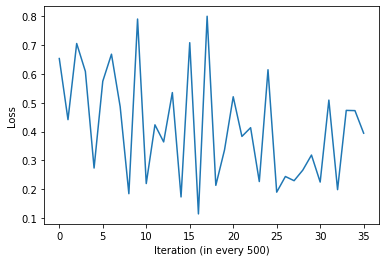

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()